In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [2]:
import os  
current_dir = os.getcwd()  
print(f"Текущая директория: {current_dir}") 

Текущая директория: c:\Projects\InvestAI_Mobile\ml


In [3]:
df = pd.read_csv("data/Stocks/aapl.us.txt", parse_dates=["Date"])

In [4]:
df.shape

(8364, 7)

In [5]:
df.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [6]:
df.tail(10)

,Date,Open,High,Low,Close,Volume,OpenInt
8354,2017-10-30,163.30,167.47,163.13,166.12,44861465,0
8355,2017-10-31,167.30,169.04,166.34,168.43,36176411,0
8356,2017-11-01,169.26,169.33,165.02,166.29,33758685,0
8357,2017-11-02,167.04,167.90,164.69,167.51,41542177,0
8358,2017-11-03,173.38,173.64,170.51,171.88,59612161,0
8359,2017-11-06,171.75,174.36,171.10,173.63,34901241,0
8360,2017-11-07,173.29,174.51,173.29,174.18,24424877,0
8361,2017-11-08,174.03,175.61,173.71,175.61,24451166,0
8362,2017-11-09,174.48,175.46,172.52,175.25,29533086,0
8363,2017-11-10,175.11,175.38,174.27,174.67,25130494,0


In [13]:
df["Date"].min(), df["Date"].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

<Axes: xlabel='Date'>

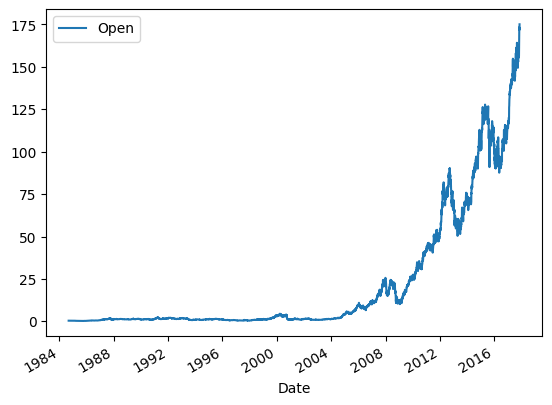

In [14]:
df.plot(x="Date", y="Open")

<Axes: xlabel='Date'>

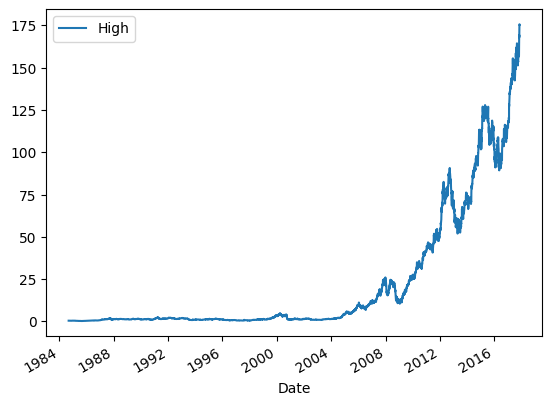

In [15]:
df.plot(x="Date", y="High")

In [7]:
df[["Open", "Close", "Low", "High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [15]:
df_9_yr = df[df["Date"] > df["Date"].max() - timedelta(days=365 * 9)]

In [16]:
df_9_yr.shape

(2265, 7)

In [17]:
df_9_yr["Date"].min(), df_9_yr["Date"].max()


(Timestamp('2008-11-13 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [18]:
train_size = int(df_9_yr.shape[0] * 0.8)
train_df = df_9_yr.iloc[:train_size]
val_df = df_9_yr.iloc[train_size:]

In [19]:
train_df.shape, val_df.shape

((1812, 7), (453, 7))

In [20]:
train_df["Date"].min(), train_df["Date"].max(), val_df["Date"].min(), val_df["Date"].max()

(Timestamp('2008-11-13 00:00:00'),
 Timestamp('2016-01-27 00:00:00'),
 Timestamp('2016-01-28 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

In [21]:
scaler = StandardScaler()
scaler.fit(train_df[["Low"]])

def make_dataset(
    df,
     window_size, 
     batch_size,
     use_scaler=True,
     shuffle=True
     ):
  features = df[["Low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["Low"].iloc[window_size:],
      sequence_length=window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size)
  return ds

In [22]:
example_ds = make_dataset(df=train_df, window_size=3, batch_size=2, use_scaler=False, shuffle=False)

In [23]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [24]:
example_feature.shape


(2, 3, 1)

In [25]:
example_label.shape


(2,)

In [26]:
train_df["Low"].iloc[:6]

6099    11.017
6100    11.526
6101    11.175
6102    11.122
6103    11.040
6104    10.245
Name: Low, dtype: float64

In [27]:
print(example_feature[0])
print(example_label[0])

[[11.017]
 [11.526]
 [11.175]]
11.122


In [28]:
print(example_feature[1])
print(example_label[1])

[[11.526]
 [11.175]
 [11.122]]
11.04


In [29]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [32]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [30]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20):
  model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
  history = model.fit(
      train_ds, 
      epochs=num_epochs,
      validation_data=val_ds,
      verbose=0
      )
  return history

In [33]:
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)

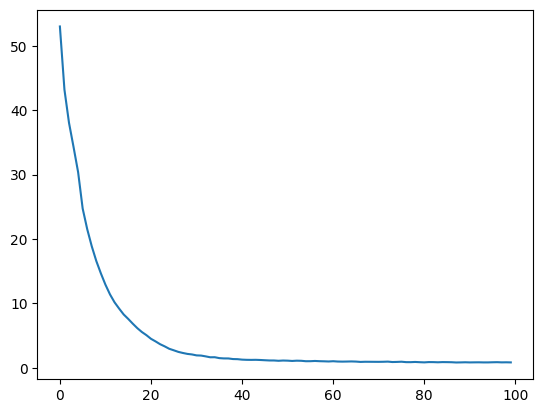

In [34]:
plt.plot(history.history['mean_absolute_error'])

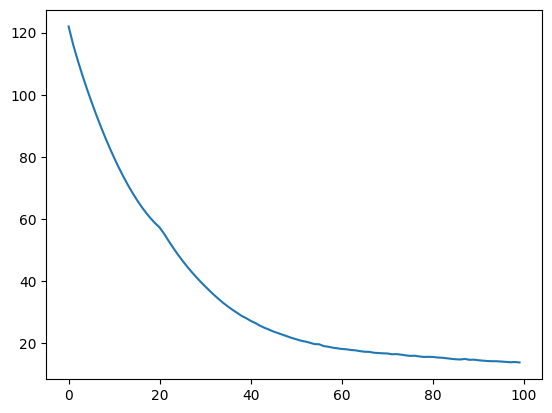

In [36]:
plt.plot(history.history['val_mean_absolute_error'])

In [35]:
lstm_model.evaluate(train_ds)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1.6077 - mean_absolute_error: 0.8965


[1.6077278852462769, 0.8965286016464233]

In [36]:
lstm_model.evaluate(val_ds)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 115.4085 - mean_absolute_error: 6.8462


[115.40852355957031, 6.846222877502441]

In [37]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500)

In [38]:
lstm_model.evaluate(train_ds)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 1.2040 - mean_absolute_error: 0.7205


[1.204004168510437, 0.7204909920692444]

In [39]:
lstm_model.evaluate(val_ds)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 91.7734 - mean_absolute_error: 6.3694


[91.77344512939453, 6.36941385269165]

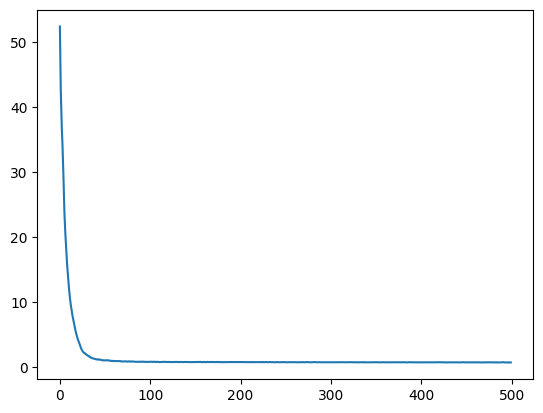

In [40]:
plt.plot(history.history['mean_absolute_error'])

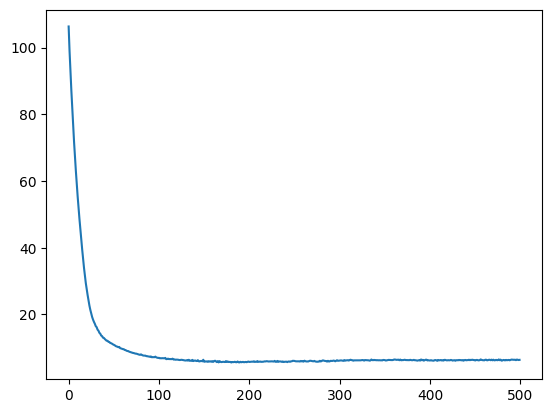

In [41]:
plt.plot(history.history['val_mean_absolute_error'])

In [42]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500)

In [43]:
lstm_model.evaluate(train_ds)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 3.0923 - mean_absolute_error: 1.2301


[3.092339038848877, 1.2300599813461304]

In [44]:
lstm_model.evaluate(val_ds)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 66.3028 - mean_absolute_error: 6.2093


[66.30282592773438, 6.209274768829346]

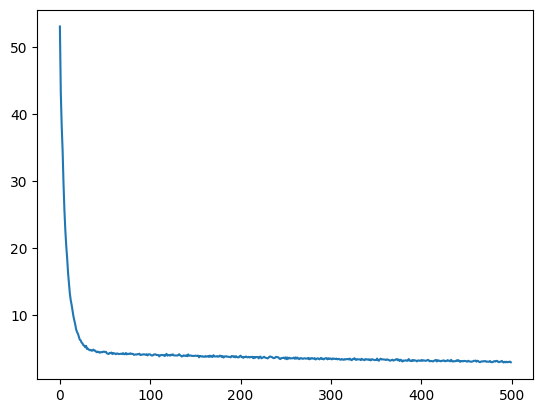

In [45]:
plt.plot(history.history['mean_absolute_error'])

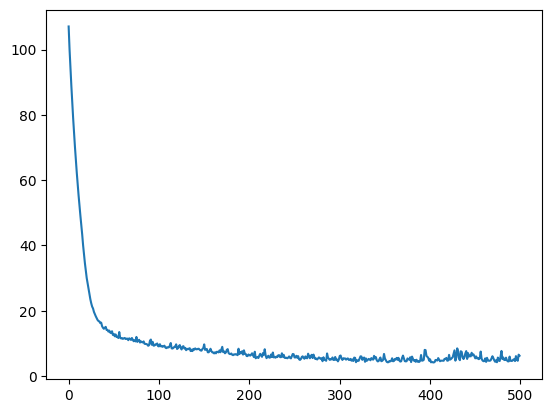

In [46]:
plt.plot(history.history['val_mean_absolute_error'])

In [52]:
def predict_low_by_date(
    model,
    df: pd.DataFrame,
    date: pd.Timestamp,
    window_size: int,
    scaler: StandardScaler
):
    if date not in df["Date"].values:
        raise ValueError("Такой даты нет в датасете")

    idx = df.index[df["Date"] == date][0]

    if idx < window_size:
        raise ValueError("Недостаточно данных перед этой датой")

    window = df.loc[idx - window_size: idx - 1, ["Low"]].values
    window_scaled = scaler.transform(window)
    window_scaled = window_scaled.reshape(1, window_size, 1)

    pred = model.predict(window_scaled, verbose=0)

    # ВАЖНО: pred уже в реальном масштабе
    return float(pred[0, 0])


In [54]:
date = pd.Timestamp("2016-06-03")
pred_low = predict_low_by_date(
    model=lstm_model,
    df=df_9_yr,
    date=date,
    window_size=10,
    scaler=scaler
)

print("Предсказанный Low:", pred_low)

idx = df_9_yr.index[df_9_yr["Date"] == date][0]

fact_low = df_9_yr.loc[idx + 1, "Low"]

print("Фактический Low:", fact_low)
print("Абсолютная ошибка:", abs(pred_low - fact_low))

Предсказанный Low: 92.02050018310547
Фактический Low: 95.0
Абсолютная ошибка: 2.9794998168945312


c:\Projects\InvestAI_Mobile\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1. Сохранение модели из Python для Android

Для Android нельзя напрямую использовать .h5 / .keras.
Нужно TensorFlow Lite (.tflite).

In [ ]:
# экспортируем keras-модель для работы с TensorFlow Lite
lstm_model.export('models')


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


Saved artifact at 'models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1938619376720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619376144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619367696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619370192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619370384: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
from tensorflow import keras
keras_file = 'model.keras'
keras.models.save_model(lstm_model, keras_file)

In [83]:
# сохраняем keras-модель
lstm_model.save("low_predict_model.keras")


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model("low_predict_model.keras")

tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)


AttributeError: module 'tensorflow._api.v2.lite' has no attribute 'TocoConverter'

In [88]:
import joblib

joblib.dump(scaler, "low_scaler.pkl")


['low_scaler.pkl']

In [87]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("models")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("low_predict_model.tflite", "wb") as f:
    f.write(tflite_model)


ConverterError: <unknown>:0: error: loc(callsite(fused["TensorListReserve:", "sequential_2_1/lstm_2_1/TensorArrayV2_1@__inference___call___1273293"] at callsite(fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper___call___1273324"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]))): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(callsite(fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper___call___1273324"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): called from
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(fused["TensorListReserve:", "sequential_2_1/lstm_2_1/TensorArrayV2_1@__inference___call___1273293"] at callsite(fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper___call___1273324"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]))): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(callsite(fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper___call___1273324"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): called from
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [90]:
import tensorflow as tf

# ВАЖНО: сохраняем обычным save, НЕ export
lstm_model.save("low_predict_model.keras")

model = tf.keras.models.load_model("low_predict_model.keras")

converter = tf.lite.TFLiteConverter.from_saved_model(model)

# разрешаем TF операции
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# отключаем попытку "упростить" TensorList
converter._experimental_lower_tensor_list_ops = False

# (опционально) оптимизация
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("low_predict_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite модель успешно сохранена")


c:\Projects\InvestAI_Mobile\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


TypeError: Expected binary or unicode string, got <Sequential name=sequential_2, built=True>

In [91]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("low_predict_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite модель успешно создана")


INFO:tensorflow:Assets written to: C:\Users\horoshev\AppData\Local\Temp\tmp7fv86mgj\assets


INFO:tensorflow:Assets written to: C:\Users\horoshev\AppData\Local\Temp\tmp7fv86mgj\assets


Saved artifact at 'C:\Users\horoshev\AppData\Local\Temp\tmp7fv86mgj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1938619376720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619376144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619367696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619370192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938619370384: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite модель успешно создана


In [92]:
import numpy as np
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="low_predict_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input:", input_details)
print("Output:", output_details)

# тестовый вход (форма должна совпадать)
x_test = np.random.randn(1, 10, 1).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], x_test)
interpreter.invoke()

pred = interpreter.get_tensor(output_details[0]['index'])
print("TFLite prediction:", pred)


c:\Projects\InvestAI_Mobile\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


RuntimeError: Select TensorFlow op(s), included in the given model, is(are) not supported by this interpreter. Make sure you apply/link the Flex delegate before inference. For the Android, it can be resolved by adding "org.tensorflow:tensorflow-lite-select-tf-ops" dependency. See instructions: https://www.tensorflow.org/lite/guide/ops_selectNode number 1 (FlexTensorListReserve) failed to prepare.